In [192]:
import os
import random

# Get all images from random set
dataset_path = '../../data/vehicle-type-detection/'

def select_random_image():
    categories = ['hatchback', 'motorcycle', 'pickup', 'sedan', 'suv']
    random_number = random.randint(0, len(categories) - 1)
    selected_category = categories[random_number]
    category_path = os.path.join(dataset_path, selected_category)

    image_files = os.listdir(category_path)
    image_paths = []

    for image_file in image_files:
        image_path = os.path.join(category_path, image_file)
        image_paths.append(image_path)

    return image_paths


In [193]:
import numpy as np

# Process image
def process_image(image_path):
    img = Image.open(image_path)
    grayscale_img = img.convert("L")
    img_array = np.array(grayscale_img)
    normalized_img = img_array / 255.0
    return normalized_img

In [194]:
from PIL import Image

# Convert images to a 2D matrix
def images_to_matrix(image_paths, target_size=(128, 128)):
    images = []
    original_shapes = []

    for image_path in image_paths:
        img = Image.open(image_path).convert('L')  # Convert to grayscale
        original_shapes.append(img.size)  # Store original shape (width, height)
        img_resized = img.resize(target_size)      # Resize the image to the target size
        img_array = np.array(img_resized).flatten()  # Flatten the image into a 1D array
        images.append(img_array)

    return np.array(images), original_shapes

In [195]:
from sklearn.decomposition import PCA

def pca_sklearn(images_matrix, k):
    pca = PCA(n_components=k)
    reduced_data = pca.fit_transform(images_matrix)
    return reduced_data, pca.components_, pca.mean_

In [196]:
image_paths = select_random_image()
images_matrix, original_shape = images_to_matrix(image_paths, target_size=(128, 128))
print('Original image shape:', original_shape[0])

Original image shape: (551, 395)


In [197]:
amt_ks = 3
random_ks = [5, 30, 90]
random_ks.sort(reverse=True)
reduced_data_list = []
principal_components_list = []
mean_image_list = []
for k in random_ks:
    reduced_data, principal_components, mean_image = pca_sklearn(images_matrix, k)
    reduced_data_list.append(reduced_data)
    principal_components_list.append(principal_components)
    mean_image_list.append(mean_image)

In [198]:
def reconstruct_images(reduced_data, principal_components, mean_image, target_size=(128, 128)):
    # Project the reduced data back to the original space
    reconstructed_images_flattened = np.dot(reduced_data, principal_components) + mean_image
    print('Reconstructed images shape:', reconstructed_images_flattened.shape)

    # Reshape each reconstructed image back to the target size
    reconstructed_images = []
    for i in range(reconstructed_images_flattened.shape[0]):
        img_reshaped = reconstructed_images_flattened[i].reshape(target_size)  # Reshape to target dimensions (128, 128)
        reconstructed_images.append(img_reshaped)

    return reconstructed_images

In [199]:
reconstructed_images = []

for i in range(amt_ks):
    reconstructed_images.append(reconstruct_images(reduced_data_list[i], principal_components_list[i], mean_image_list[i], target_size=(128, 128)))

Reconstructed images shape: (129, 16384)
Reconstructed images shape: (129, 16384)
Reconstructed images shape: (129, 16384)


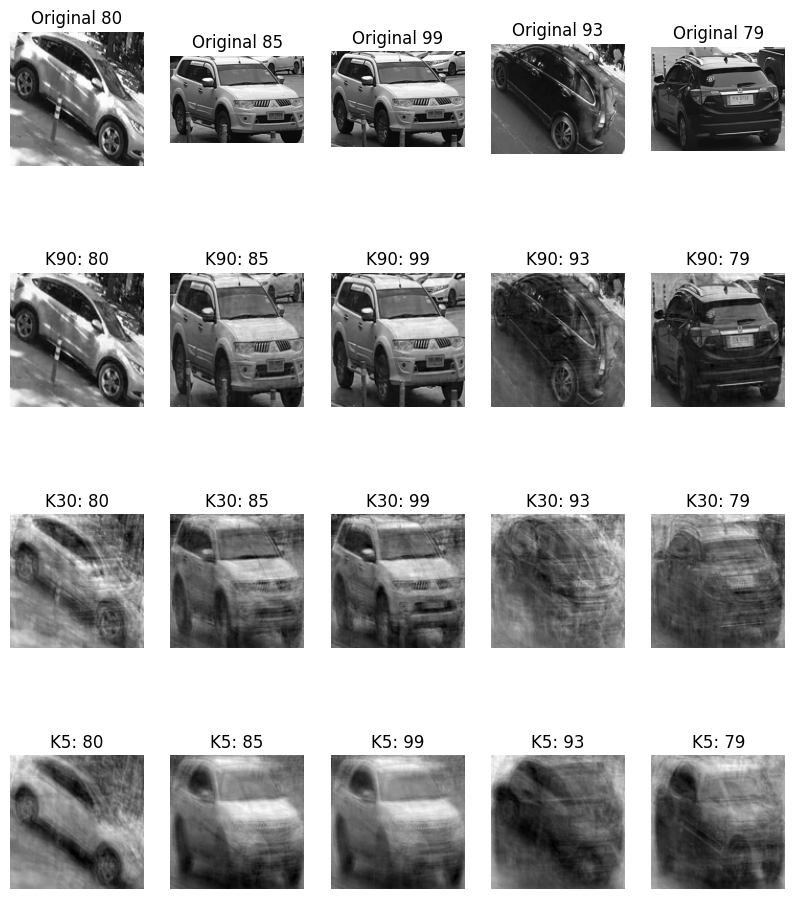

In [200]:
import matplotlib.pyplot as plt

# Display original and reconstructed images side by side
def plot_images_with_shapes(original_paths, reconstructed_images, amt_ks, num_images=5):

    random_indices = random.sample(range(len(original_paths)), num_images)

    fig, axes = plt.subplots(amt_ks+1, num_images, figsize=(10, amt_ks*4))

    for i, idx in enumerate(random_indices):
        # Plot original image
        original_img = Image.open(original_paths[idx]).convert('L')
        axes[0, i].imshow(original_img, cmap='gray')
        axes[0, i].set_title(f'Original {idx+1}')
        axes[0, i].axis('off')

        # Plot reconstructed image
        for j in range(amt_ks):
            axes[j+1, i].imshow(reconstructed_images[j][idx], cmap='gray')
            axes[j+1, i].set_title(f'K{random_ks[j]}: {idx+1}')
            axes[j+1, i].axis('off')




    plt.show()

# Example usage with image paths and reconstructed images
plot_images_with_shapes(image_paths, reconstructed_images, amt_ks, num_images=5)

Mean Squared Error (MSE) for k=90: 150.03458820676238
Mean Squared Error (MSE) for k=30: 849.1750926383357
Mean Squared Error (MSE) for k=5: 1813.6653116499333
Mean Squared Error (MSE) for k=90: 150.03458820676238
Mean Squared Error (MSE) for k=30: 849.1750926383357
Mean Squared Error (MSE) for k=5: 1813.6653116499333


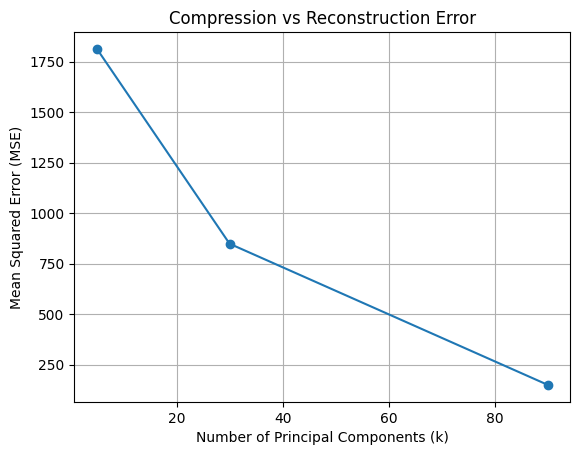

In [201]:
from sklearn.metrics import mean_squared_error

def resize_images_to_target(original_paths, target_size=(128, 128)):
    resized_images = []
    for image_path in original_paths:
        img = Image.open(image_path).convert('L')
        img_resized = img.resize(target_size)
        resized_images.append(np.array(img_resized))
    return resized_images

# Resize original images to the target size (128x128)
resized_original_images = resize_images_to_target(image_paths, target_size=(128, 128))

# Function to compute MSE between original and reconstructed images
def compute_mse(original_images, reconstructed_images):
    mse_values = []
    for original, reconstructed in zip(original_images, reconstructed_images):
        mse = mean_squared_error(original.flatten(), reconstructed.flatten())
        mse_values.append(mse)
    return np.mean(mse_values)

# Trade-off analysis
def analyze_compression_vs_error(original_images, reconstructed_images, ks, amt_ks):
    mse_values = []
    for i in range(amt_ks):
        mse = compute_mse(original_images, reconstructed_images[i])
        mse_values.append(mse)
        print(f"Mean Squared Error (MSE) for k={ks[i]}: {mse}")

    return ks, mse_values

# Perform trade-off analysis
ks, mse_values = analyze_compression_vs_error(resized_original_images, reconstructed_images, random_ks, amt_ks)


mse_values = []
for i in range(amt_ks):
    mse = compute_mse(resized_original_images, reconstructed_images[i])
    mse_values.append(mse)
    print(f"Mean Squared Error (MSE) for k={random_ks[i]}: {mse}")

# Plot the trade-off between compression (k) and reconstruction error (MSE)
plt.plot(ks, mse_values, marker='o')
plt.xlabel('Number of Principal Components (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Compression vs Reconstruction Error')
plt.grid(True)
plt.show()